In [0]:
import os

path = "/Volumes/workspace/test/testvol/cookie-monster.jpg"
os.path.exists(path)


True

(np.float64(-0.5), np.float64(999.5), np.float64(999.5), np.float64(-0.5))

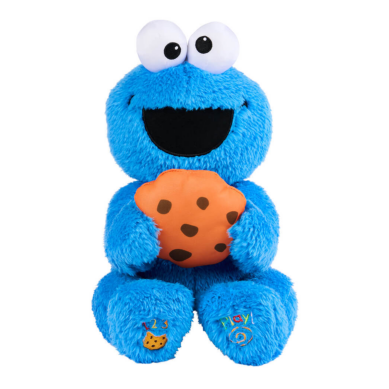

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

img = Image.open(path).convert("RGB")
img = np.array(img)

plt.imshow(img)
plt.axis("off")


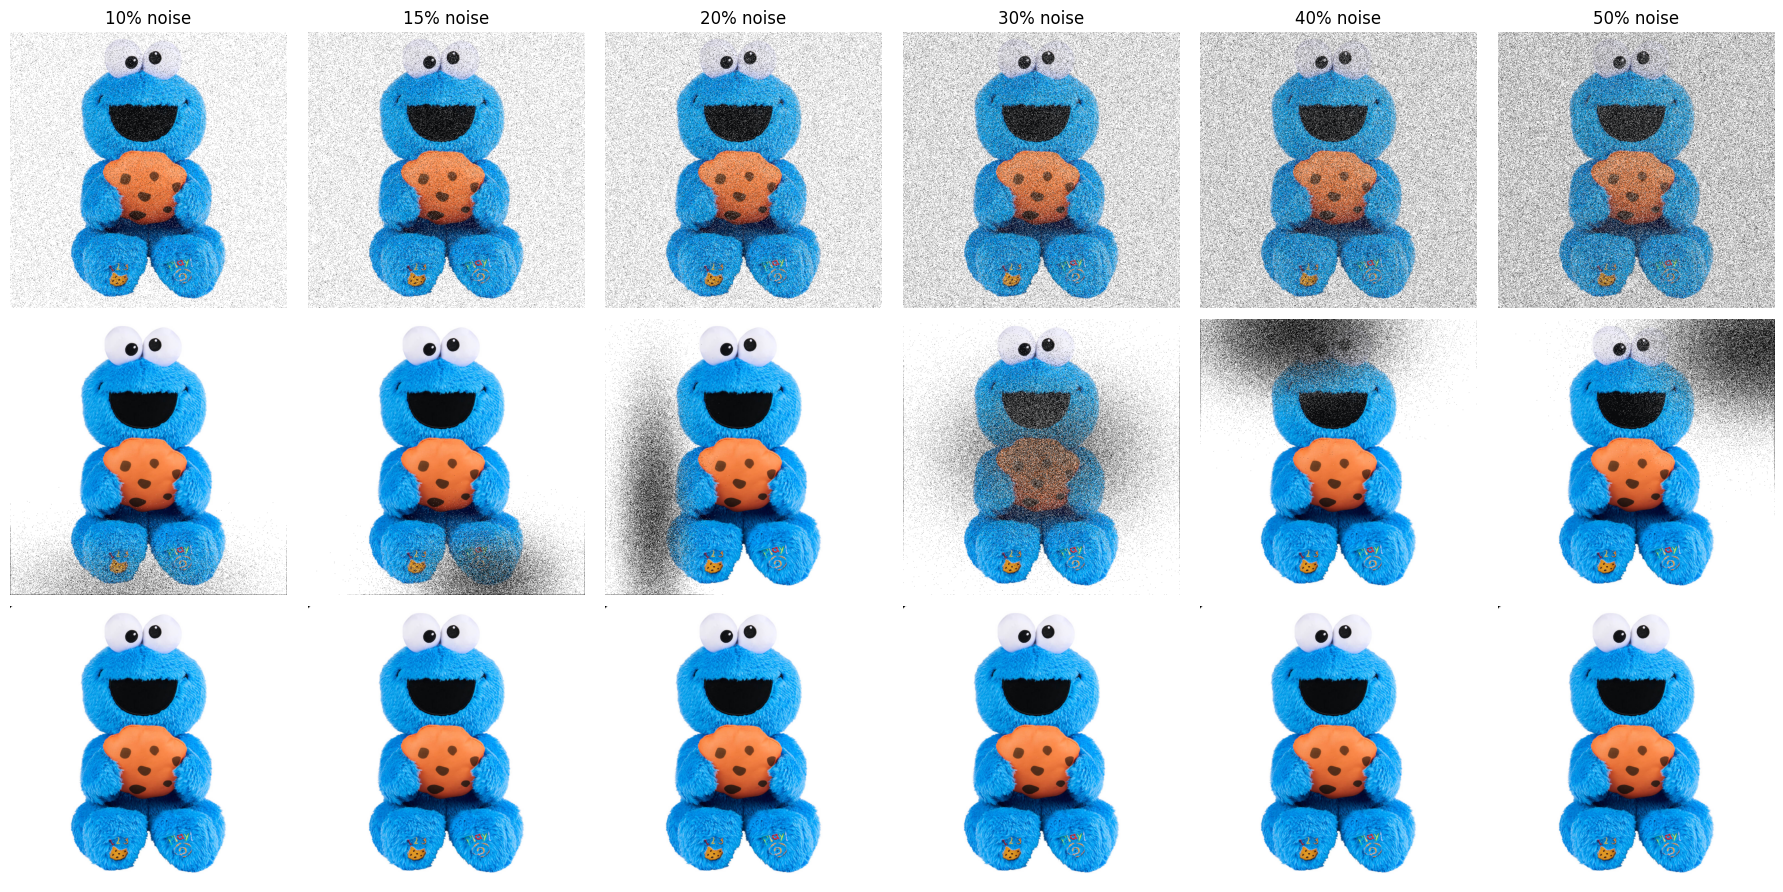

In [0]:

H, W, C = img.shape
# (1000, 1000, 3)

noise_ratios = [10, 15, 20, 30, 40, 50]

# -----------------------------
# Generate spatial coordinates
# -----------------------------
def sample_coordinates(distribution, num_points):
    if distribution == "uniform":
        xs = np.random.randint(0, H, num_points)
        ys = np.random.randint(0, W, num_points)

    elif distribution == "gaussian":
        mu_x = np.random.uniform(0, H)
        mu_y = np.random.uniform(0, W)
        sigma_x = np.random.uniform(H * 0.05, H * 0.25)
        sigma_y = np.random.uniform(W * 0.05, W * 0.25)

        xs = np.random.normal(mu_x, sigma_x, num_points).astype(int)
        ys = np.random.normal(mu_y, sigma_y, num_points).astype(int)

        xs = np.clip(xs, 0, H - 1)
        ys = np.clip(ys, 0, W - 1)

    elif distribution == "exponential":
        xs = np.random.exponential(scale=1.0, size=num_points).astype(int) % H
        ys = np.random.exponential(scale=1.0, size=num_points).astype(int) % W

    return xs, ys

# -----------------------------
# Apply salt & pepper noise
# -----------------------------
def apply_salt_pepper(image, xs, ys):
    noisy = image.copy()
    n = len(xs)
    half = n // 2

    # Salt (white)
    noisy[xs[:half], ys[:half]] = 255

    # Pepper (black)
    noisy[xs[half:], ys[half:]] = 0

    return noisy

# -----------------------------
# Plot results
# -----------------------------
distributions = ["uniform", "gaussian", "exponential"]

fig, axes = plt.subplots(3, 6, figsize=(18, 9))

for i, dist in enumerate(distributions):
    for j, ratio in enumerate(noise_ratios):
        num_pixels = int((ratio / 100) * H * W)
        xs, ys = sample_coordinates(dist, num_pixels)
        noisy_img = apply_salt_pepper(img, xs, ys)

        axes[i, j].imshow(noisy_img)
        axes[i, j].axis("off")

        if i == 0:
            axes[i, j].set_title(f"{ratio}% noise")

        if j == 0:
            axes[i, j].set_ylabel(dist.capitalize(), fontsize=12)

plt.tight_layout()
plt.show()


(np.float64(-0.5), np.float64(649.5), np.float64(469.5), np.float64(-0.5))

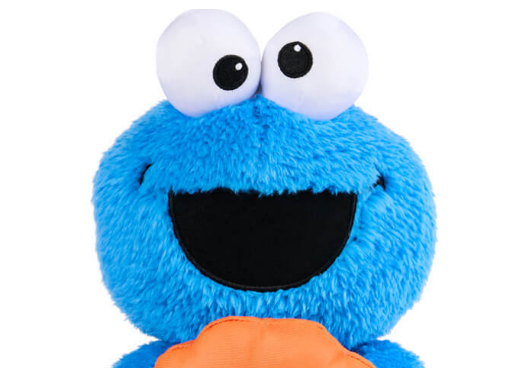

In [0]:
face_x1, face_y1 = 150, 30
face_x2, face_y2 = 800, 500

im= img[face_y1:face_y2, face_x1:face_x2]
plt.imshow(im)
plt.axis("off")

In [0]:

face_mask = np.zeros((H, W), dtype=bool)
face_mask[face_y1:face_y2, face_x1:face_x2] = True
face_pixel_count = face_mask.sum()

# -----------------------------
# Parameters
# -----------------------------
noise_ratios_new = [20, 30, 40, 50]
distributions = ["uniform", "gaussian", "exponential"]
num_trials = 100
corruption_threshold = 0.20  # 20%


# -----------------------------
# Simulation
# -----------------------------
results = {}

for dist in distributions:
    results[dist] = {}

    for ratio in noise_ratios_new:
        corrupted_faces = 0
        n_pixels = int((ratio / 100) * H * W)

        for _ in range(num_trials):
            xs, ys = sample_coordinates(dist, n_pixels)

            noise_mask = np.zeros((H, W), dtype=bool)
            noise_mask[xs, ys] = True

            corrupted_face_pixels = np.logical_and(noise_mask, face_mask).sum()
            corrupted_ratio = corrupted_face_pixels / face_pixel_count

            if corrupted_ratio >= corruption_threshold:
                corrupted_faces += 1

        results[dist][ratio] = corrupted_faces

# -----------------------------
# Report results
# -----------------------------
print("Average corrupted face counts (out of 100):\n")

for dist in distributions:
    print(dist.capitalize())
    for ratio in noise_ratios_new:
        print(f"  Noise {ratio}% → {results[dist][ratio]} corrupted faces")
    print()

Average corrupted face counts (out of 100):

Uniform
  Noise 20% → 0 corrupted faces
  Noise 30% → 100 corrupted faces
  Noise 40% → 100 corrupted faces
  Noise 50% → 100 corrupted faces

Gaussian
  Noise 20% → 27 corrupted faces
  Noise 30% → 33 corrupted faces
  Noise 40% → 43 corrupted faces
  Noise 50% → 52 corrupted faces

Exponential
  Noise 20% → 0 corrupted faces
  Noise 30% → 0 corrupted faces
  Noise 40% → 0 corrupted faces
  Noise 50% → 0 corrupted faces



When **Gaussian** or **Uniform** noise is applied to the entire image, each pixel has a **certain probability** of being corrupted.

For example, if 20% noise is applied → each pixel in the image has approximately a **20% chance of being corrupted**.

Now, if we only look at a small part of the image, like the **face (ROI)**:  
- The same probability rule applies.  
- That means each pixel inside the ROI also has roughly a **20% chance of being corrupted**.

Therefore, when we calculate the average over **100 trials**:  
- The percentage of corrupted pixels in the ROI ≈ the percentage of noise applied to the entire image.

> This explains why Gaussian noise with random μ and σ, over multiple trials, results in the **average ROI corruption being approximately equal to the overall noise percentage**.


In [0]:
%pip install opencv-python-headless


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 92.5 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


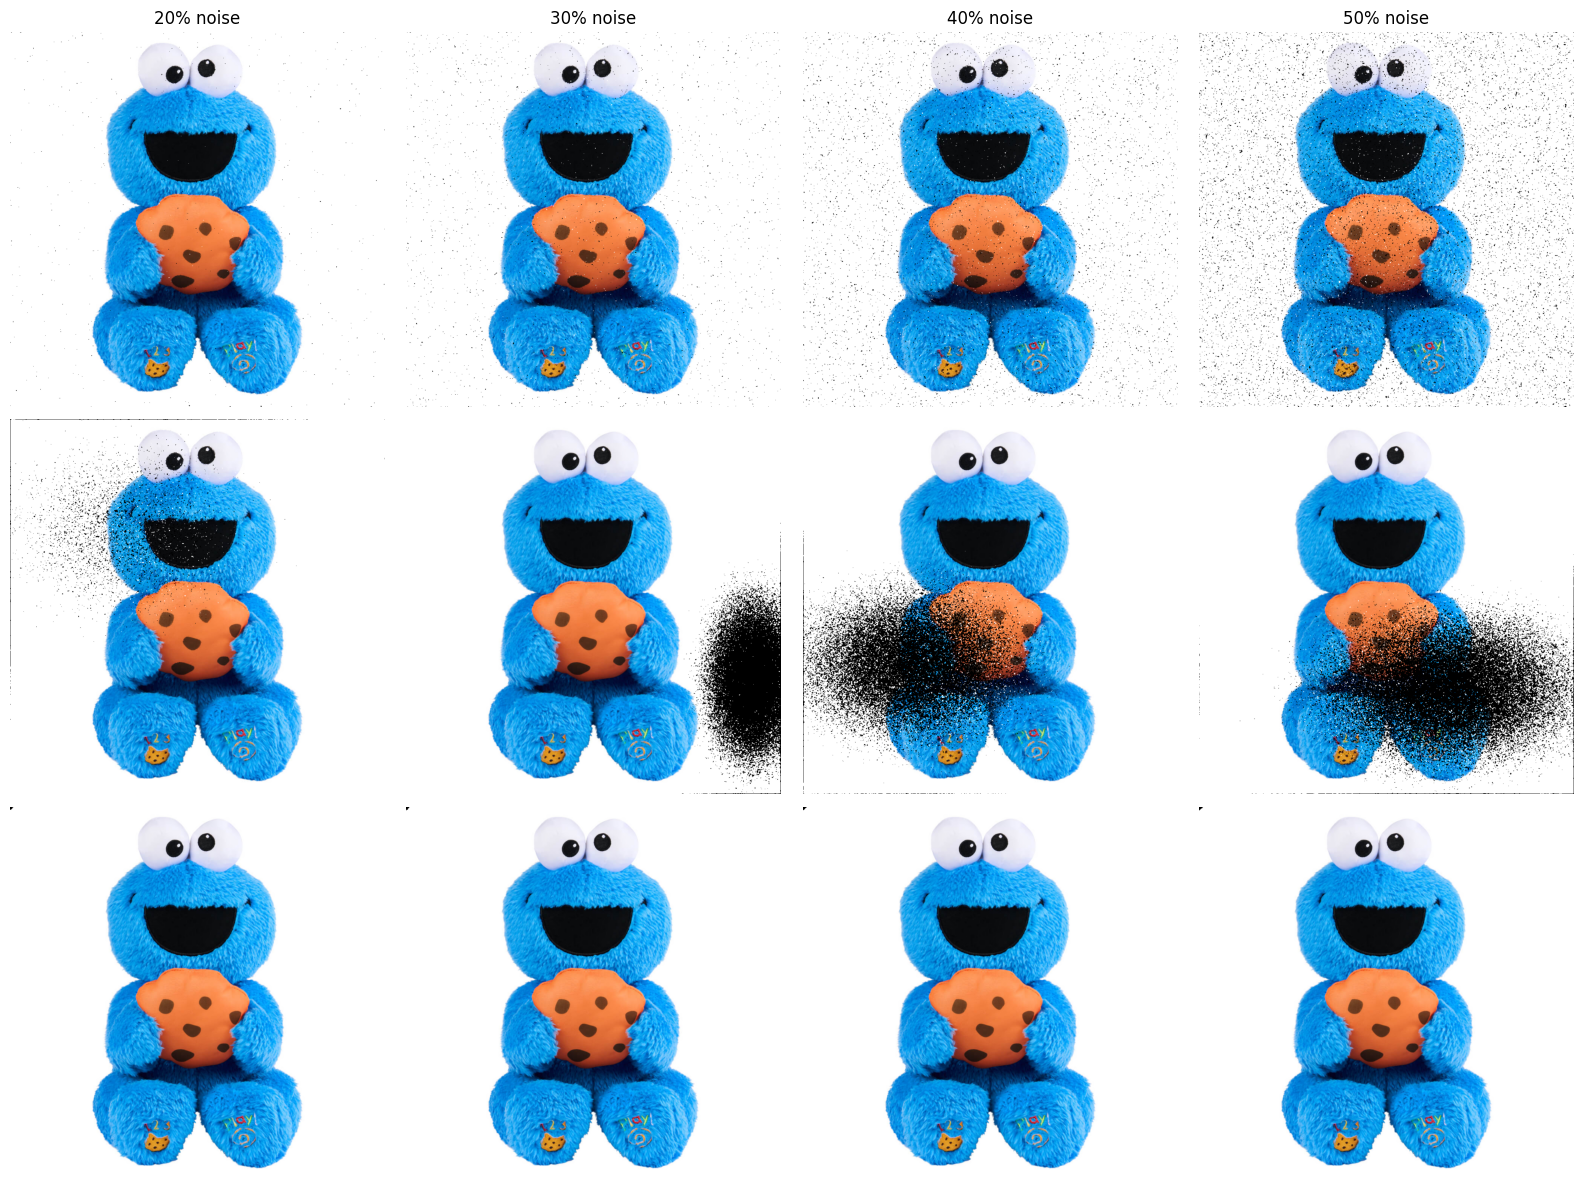

In [0]:
import cv2

# -----------------------------
# Apply median filter (kernel size 3)
# -----------------------------
def median_filter_rgb(image, ksize=3):
    filtered = np.zeros_like(image)
    for c in range(3):  # RGB channels
        filtered[:, :, c] = cv2.medianBlur(image[:, :, c], ksize)
    return filtered



fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i, dist in enumerate(distributions):
    for j, ratio in enumerate(noise_ratios_new):
        num_pixels = int((ratio / 100) * H * W)
        xs, ys = sample_coordinates(dist, num_pixels)
        noisy_img = apply_salt_pepper(img, xs, ys)
        filtered_img = median_filter_rgb(noisy_img)

        axes[i, j].imshow(filtered_img)
        axes[i, j].axis("off")

        if i == 0:
            axes[i, j].set_title(f"{ratio}% noise")
        if j == 0:
            axes[i, j].set_ylabel(dist.capitalize(), fontsize=12)

plt.tight_layout()
plt.show()